Part - 2:
=========

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve, auc

In [34]:
df = pd.read_csv('dataset.csv')
print(df.describe())

               f3      target
count  766.000000  766.000000
mean    69.118799    0.349869
std     19.376901    0.477240
min      0.000000    0.000000
25%     62.500000    0.000000
50%     72.000000    0.000000
75%     80.000000    1.000000
max    122.000000    1.000000


In [35]:
# we see that there are alphabets in numeric columns so we replace them with mean of that respective column
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].mean(), inplace=True)
df.tail

<bound method NDFrame.tail of             f1     f2  f3         f4          f5        f6        f7  target
0     6.000000  148.0  72  35.000000    0.000000  33.60000  0.627000       1
1     1.000000   85.0  66  29.000000    0.000000  26.60000  0.351000       0
2     8.000000  183.0  64   0.000000    0.000000  23.30000  0.672000       1
3     1.000000   89.0  66  23.000000   94.000000  28.10000  0.167000       0
4     0.000000  137.0  40  35.000000  168.000000  43.10000  2.288000       1
..         ...    ...  ..        ...         ...       ...       ...     ...
761   9.000000   89.0  62   0.000000    0.000000  22.50000  0.472128       0
762  10.000000  101.0  76  48.000000  180.000000  31.99817  0.171000       0
763   2.000000  122.0  70  27.000000   80.091503  36.80000  0.340000       0
764   3.849673  121.0  72  23.000000  112.000000  26.20000  0.245000       0
765   1.000000  126.0  60  20.542484    0.000000  30.10000  0.349000       1

[766 rows x 8 columns]>

In [36]:
scaler = StandardScaler()
df1 = df.drop('target', axis=1)
column = df1.columns
df1[column] = scaler.fit_transform(df1[column])
df1['target'] = df['target']
df1.tail

<bound method NDFrame.tail of                f1        f2        f3            f4        f5            f6  \
0    6.382139e-01  0.849057  0.148790  9.070150e-01 -0.695096  2.030729e-01   
1   -8.457789e-01 -1.125480 -0.161060  5.305956e-01 -0.695096 -6.843559e-01   
2    1.231811e+00  1.946022 -0.264343 -1.288765e+00 -0.695096 -1.102715e+00   
3   -8.457789e-01 -1.000113 -0.161060  1.541762e-01  0.120709 -4.941926e-01   
4   -1.142577e+00  0.504297 -1.503740  9.070150e-01  0.762938  1.407440e+00   
..            ...       ...       ...           ...       ...           ...   
761  1.528610e+00 -1.000113 -0.367626 -1.288765e+00 -0.695096 -1.204136e+00   
762  1.825408e+00 -0.624010  0.355356  1.722590e+00  0.867083  4.503972e-16   
763 -5.489804e-01  0.034169  0.045507  4.051224e-01  0.000000  6.087546e-01   
764  1.318050e-16  0.002827  0.148790  1.541762e-01  0.276927 -7.350661e-01   
765 -8.457789e-01  0.159536 -0.470909  2.228851e-16 -0.695096 -2.406415e-01   

               f7  ta

In [37]:
X = df.drop('target', axis=1)
Y = df['target']
oversampler = RandomOverSampler(random_state=42)
X, Y = oversampler.fit_resample(X, Y)
# We split the dataset into training and testing sets: 85 training and 15 percent testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
# We further split the training data into training and validation sets: the final sizes are: 70 training and 15 percent validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
Y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
print("X_train tensor size: ", X_train_tensor.shape)
print("Y_train tensor size: ", Y_train_tensor.shape)
print("X_val tensor size: ", X_val_tensor.shape)
print("Y_val tensor size: ", Y_val_tensor.shape)
print("X_test tensor size: ", X_test_tensor.shape)
print("Y_test tensor size: ", Y_test_tensor.shape)

X_train tensor size:  torch.Size([697, 7])
Y_train tensor size:  torch.Size([697])
X_val tensor size:  torch.Size([149, 7])
Y_val tensor size:  torch.Size([149])
X_test tensor size:  torch.Size([150, 7])
Y_test tensor size:  torch.Size([150])


Tuning hyperparameters:
=======================
1. Dropout value:
-----------------

In [38]:
class NN_dropout(nn.Module):
    def __init__(self, input, hidden, output, dropout_rate):
        super(NN_dropout, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, output)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [39]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
dropout_rate = [0.3, 0.5, 0.7]
for dropout in dropout_rate:
    model = NN_dropout(input_size, hidden_size, output_size, dropout)

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.007)

    total_epochs = 300
    batch_size = 64
    best_val_loss = float('inf')

    train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels.unsqueeze(1).float())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            correct_train += (predictions.squeeze(1) == labels).sum().item()

        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / len(train_dataloader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

                val_predictions = torch.round(torch.sigmoid(val_outputs))
                correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

        val_loss /= len(val_dataloader.dataset)
        val_accuracy = correct_val / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if (epoch+1)%10==0:
            print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
                f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"Dropout: {dropout}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")



Epoch 10/300, Training Loss: 0.6716, Validation Loss: 0.6420, Training Accuracy: 0.6126, Validation Accuracy: 0.6779
Epoch 20/300, Training Loss: 0.6449, Validation Loss: 0.6140, Training Accuracy: 0.6471, Validation Accuracy: 0.7181
Epoch 30/300, Training Loss: 0.6527, Validation Loss: 0.6167, Training Accuracy: 0.6542, Validation Accuracy: 0.6779
Epoch 40/300, Training Loss: 0.6287, Validation Loss: 0.5944, Training Accuracy: 0.6571, Validation Accuracy: 0.7181
Epoch 50/300, Training Loss: 0.5969, Validation Loss: 0.5824, Training Accuracy: 0.7116, Validation Accuracy: 0.7315
Epoch 60/300, Training Loss: 0.6091, Validation Loss: 0.5906, Training Accuracy: 0.6772, Validation Accuracy: 0.7047
Epoch 70/300, Training Loss: 0.5991, Validation Loss: 0.5812, Training Accuracy: 0.6901, Validation Accuracy: 0.7114
Epoch 80/300, Training Loss: 0.5969, Validation Loss: 0.6031, Training Accuracy: 0.6829, Validation Accuracy: 0.6577
Epoch 90/300, Training Loss: 0.5823, Validation Loss: 0.5613, Tr


2. Batch size:
---------------

In [40]:
class NN_batchsize_lr(nn.Module):
    def __init__(self, input, hidden, output):
        super(NN_batchsize_lr, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, output)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [41]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)
batch_size_list = [32, 64, 128]
for batch in batch_size_list:
    
    total_epochs = 300
    batch_size = batch
    best_val_loss = float('inf')

    train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels.unsqueeze(1).float())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            correct_train += (predictions.squeeze(1) == labels).sum().item()

        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / len(train_dataloader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

                val_predictions = torch.round(torch.sigmoid(val_outputs))
                correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

        val_loss /= len(val_dataloader.dataset)
        val_accuracy = correct_val / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if (epoch+1)%10==0:
            print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
                f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"Batch size: {batch_size}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")



Epoch 10/300, Training Loss: 0.6761, Validation Loss: 0.6694, Training Accuracy: 0.5667, Validation Accuracy: 0.6174
Epoch 20/300, Training Loss: 0.6779, Validation Loss: 0.6514, Training Accuracy: 0.5925, Validation Accuracy: 0.6174
Epoch 30/300, Training Loss: 0.6657, Validation Loss: 0.6351, Training Accuracy: 0.6169, Validation Accuracy: 0.6309
Epoch 40/300, Training Loss: 0.6723, Validation Loss: 0.6430, Training Accuracy: 0.6011, Validation Accuracy: 0.6242
Epoch 50/300, Training Loss: 0.6484, Validation Loss: 0.6131, Training Accuracy: 0.6298, Validation Accuracy: 0.6846
Epoch 60/300, Training Loss: 0.6360, Validation Loss: 0.5987, Training Accuracy: 0.6413, Validation Accuracy: 0.7114
Epoch 70/300, Training Loss: 0.6502, Validation Loss: 0.5922, Training Accuracy: 0.6456, Validation Accuracy: 0.6980
Epoch 80/300, Training Loss: 0.6067, Validation Loss: 0.5877, Training Accuracy: 0.6815, Validation Accuracy: 0.7114
Epoch 90/300, Training Loss: 0.6288, Validation Loss: 0.5816, Tr

3. Learning Rate:
-------------------

In [42]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

learning_rates = [0.001, 0.007, 0.01]
for learning in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=learning)
    total_epochs = 300
    batch_size = 64
    best_val_loss = float('inf')

    train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels.unsqueeze(1).float())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            correct_train += (predictions.squeeze(1) == labels).sum().item()

        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / len(train_dataloader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

                val_predictions = torch.round(torch.sigmoid(val_outputs))
                correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

        val_loss /= len(val_dataloader.dataset)
        val_accuracy = correct_val / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if (epoch+1)%10==0:
            print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
                f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    test_losses = [test_loss] * total_epochs
    test_accuracies = [test_accuracy] * total_epochs

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"Learning Rate: {learning}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")



Epoch 10/300, Training Loss: 0.8269, Validation Loss: 0.6920, Training Accuracy: 0.4950, Validation Accuracy: 0.5906
Epoch 20/300, Training Loss: 0.7257, Validation Loss: 0.6872, Training Accuracy: 0.5036, Validation Accuracy: 0.5705
Epoch 30/300, Training Loss: 0.6895, Validation Loss: 0.6844, Training Accuracy: 0.5337, Validation Accuracy: 0.5839
Epoch 40/300, Training Loss: 0.6766, Validation Loss: 0.6813, Training Accuracy: 0.5395, Validation Accuracy: 0.5638
Epoch 50/300, Training Loss: 0.6750, Validation Loss: 0.6759, Training Accuracy: 0.5725, Validation Accuracy: 0.6040
Epoch 60/300, Training Loss: 0.6597, Validation Loss: 0.6693, Training Accuracy: 0.6083, Validation Accuracy: 0.5772
Epoch 70/300, Training Loss: 0.6723, Validation Loss: 0.6660, Training Accuracy: 0.6126, Validation Accuracy: 0.5839
Epoch 80/300, Training Loss: 0.6625, Validation Loss: 0.6598, Training Accuracy: 0.6055, Validation Accuracy: 0.5973
Epoch 90/300, Training Loss: 0.6577, Validation Loss: 0.6544, Tr

#### Base Model:

In [43]:
class NN_batchsize_lr(nn.Module):
    def __init__(self, input, hidden, output):
        super(NN_batchsize_lr, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, output)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [44]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)
    
total_epochs = 300
batch_size = 64
best_val_loss = float('inf')

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies_base_model = []
start_time_base_model = time.time()
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
            f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = accuracy_score(y_true, y_pred)
    test_accuracies_base_model.append(test_accuracy) # This stores the test accuracy after each epoch

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end_time_base_model = time.time()
print(f"Training completed in: {(end_time_base_model - start_time_base_model) / 60:.2f} minutes")
        
model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_losses = [test_loss] * total_epochs
test_accuracies = [test_accuracy] * total_epochs

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Batch size: {batch_size}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")



Epoch 10/300, Training Loss: 0.6612, Validation Loss: 0.6382, Training Accuracy: 0.6069, Validation Accuracy: 0.6779
Epoch 10/300, Test Loss: 0.6459, Test Accuracy: 0.6000
Epoch 20/300, Training Loss: 0.6359, Validation Loss: 0.6199, Training Accuracy: 0.6829, Validation Accuracy: 0.6711
Epoch 20/300, Test Loss: 0.6306, Test Accuracy: 0.6533
Epoch 30/300, Training Loss: 0.6322, Validation Loss: 0.6151, Training Accuracy: 0.6643, Validation Accuracy: 0.6711
Epoch 30/300, Test Loss: 0.6205, Test Accuracy: 0.6533
Epoch 40/300, Training Loss: 0.6139, Validation Loss: 0.5925, Training Accuracy: 0.6671, Validation Accuracy: 0.7047
Epoch 40/300, Test Loss: 0.6070, Test Accuracy: 0.6733
Epoch 50/300, Training Loss: 0.6006, Validation Loss: 0.5851, Training Accuracy: 0.6930, Validation Accuracy: 0.7114
Epoch 50/300, Test Loss: 0.5949, Test Accuracy: 0.6800
Epoch 60/300, Training Loss: 0.5798, Validation Loss: 0.5876, Training Accuracy: 0.6815, Validation Accuracy: 0.7047
Epoch 60/300, Test Loss

#### Early Stopping:

In [45]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

learning = 0.007
optimizer = optim.Adam(model.parameters(), lr=learning)
total_epochs = 300
batch_size = 64
best_val_loss = float('inf')
total_epochs_for_early_stopping = 10  # This is the number of epochs that the model waits if no improvement is seen before stopping
epochs_no_improvement = 0  # We initialize the counter to keep a count of the number of epochs without improvement

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Logic to stop early
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improvement = 0  # We are reseting the counter if the validation loss improves
    else:
        epochs_no_improvement += 1  # Increase counter if no improvement is seen
    
    if epochs_no_improvement >= total_epochs_for_early_stopping:
        print(f"Early stopping is triggered after {epoch+1} epochs!")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Testing
model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_losses = [test_loss] * total_epochs
test_accuracies = [test_accuracy] * total_epochs

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Learning Rate: {learning}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Epoch 10/300, Training Loss: 0.6598, Validation Loss: 0.6446, Training Accuracy: 0.6270, Validation Accuracy: 0.6980
Epoch 20/300, Training Loss: 0.6578, Validation Loss: 0.6212, Training Accuracy: 0.6341, Validation Accuracy: 0.6711
Epoch 30/300, Training Loss: 0.6274, Validation Loss: 0.6132, Training Accuracy: 0.6772, Validation Accuracy: 0.6846
Epoch 40/300, Training Loss: 0.6102, Validation Loss: 0.5910, Training Accuracy: 0.6743, Validation Accuracy: 0.6644
Epoch 50/300, Training Loss: 0.6028, Validation Loss: 0.5819, Training Accuracy: 0.6901, Validation Accuracy: 0.7114
Epoch 60/300, Training Loss: 0.5994, Validation Loss: 0.5736, Training Accuracy: 0.6815, Validation Accuracy: 0.7114
Epoch 70/300, Training Loss: 0.6006, Validation Loss: 0.5641, Training Accuracy: 0.6901, Validation Accuracy: 0.6980
Early stopping is triggered after 80 epochs!
Test Loss: 0.5850, Test Accuracy: 0.6533
Learning Rate: 0.007
Test Accuracy: 0.6533
Test Precision: 0.6022
Test Recall: 0.7887
Test F1 S

#### Learning Rate Scheduler

In [46]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.007)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

total_epochs = 300
batch_size = 64
best_val_loss = float('inf')

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Learning rate scheduler logic
    lr_scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Testing
model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_losses = [test_loss] * total_epochs
test_accuracies = [test_accuracy] * total_epochs

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Epoch 10/300, Training Loss: 0.6636, Validation Loss: 0.6411, Training Accuracy: 0.6212, Validation Accuracy: 0.6376
Epoch 00019: reducing learning rate of group 0 to 7.0000e-04.
Epoch 20/300, Training Loss: 0.6274, Validation Loss: 0.6044, Training Accuracy: 0.6628, Validation Accuracy: 0.6913
Epoch 00025: reducing learning rate of group 0 to 7.0000e-05.
Epoch 30/300, Training Loss: 0.6195, Validation Loss: 0.5950, Training Accuracy: 0.6772, Validation Accuracy: 0.7114
Epoch 00031: reducing learning rate of group 0 to 7.0000e-06.
Epoch 00037: reducing learning rate of group 0 to 7.0000e-07.
Epoch 40/300, Training Loss: 0.6197, Validation Loss: 0.5947, Training Accuracy: 0.6686, Validation Accuracy: 0.7114
Epoch 00043: reducing learning rate of group 0 to 7.0000e-08.
Epoch 00049: reducing learning rate of group 0 to 7.0000e-09.
Epoch 50/300, Training Loss: 0.6080, Validation Loss: 0.5947, Training Accuracy: 0.6801, Validation Accuracy: 0.7114
Epoch 60/300, Training Loss: 0.6135, Valida

#### Batch Normalization

In [47]:
class NN_batchnorm(nn.Module):
    def __init__(self, input, hidden, output):
        super(NN_batchnorm, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)  # We add BatchNorm for batch normalization
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.bn3 = nn.BatchNorm1d(hidden)
        self.fc4 = nn.Linear(hidden, output)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(self.bn1(x))  # We apply BatchNorm for batch normalization
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(self.bn2(x))  # Apply BatchNorm
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(self.bn3(x))  # Apply BatchNorm
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [48]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchnorm(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.007)
total_epochs = 300
batch_size = 64
best_val_loss = float('inf')

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies_improved = []
start_time_improved = time.time()
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
            f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = accuracy_score(y_true, y_pred)
    test_accuracies_improved.append(test_accuracy)  # Store test accuracy for this epoch

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time_improved = time.time()
print(f"Training completed in: {(end_time_improved - start_time_improved) / 60:.2f} minutes")

model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_losses = [test_loss] * total_epochs
test_accuracy = [test_accuracy] * total_epochs

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Learning Rate: {learning}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Epoch 10/300, Training Loss: 0.5212, Validation Loss: 0.5814, Training Accuracy: 0.7432, Validation Accuracy: 0.6510
Epoch 10/300, Test Loss: 0.5221, Test Accuracy: 0.7067
Epoch 20/300, Training Loss: 0.4955, Validation Loss: 0.5494, Training Accuracy: 0.7590, Validation Accuracy: 0.6846
Epoch 20/300, Test Loss: 0.4990, Test Accuracy: 0.7667
Epoch 30/300, Training Loss: 0.4786, Validation Loss: 0.5583, Training Accuracy: 0.7819, Validation Accuracy: 0.6980
Epoch 30/300, Test Loss: 0.5035, Test Accuracy: 0.7600
Epoch 40/300, Training Loss: 0.4753, Validation Loss: 0.5395, Training Accuracy: 0.7905, Validation Accuracy: 0.6913
Epoch 40/300, Test Loss: 0.4908, Test Accuracy: 0.7733
Epoch 50/300, Training Loss: 0.4679, Validation Loss: 0.5596, Training Accuracy: 0.7791, Validation Accuracy: 0.6510
Epoch 50/300, Test Loss: 0.4999, Test Accuracy: 0.7733
Epoch 60/300, Training Loss: 0.4387, Validation Loss: 0.5410, Training Accuracy: 0.7991, Validation Accuracy: 0.6644
Epoch 60/300, Test Loss

#### Gradient Accumulation

In [49]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchsize_lr(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.007)
total_epochs = 300
batch_size = 64
num_batches = 4  # We initialize the number of batches over which gradients will be accumulated
best_val_loss = float('inf')

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    optimizer.zero_grad()  # We reset the gradients before starting to accumulate
    
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        
        # We scale the loss for accumulation steps
        loss = loss / num_batches
        loss.backward()
        
        # Accumulation logic
        if (batch_idx + 1) % num_batches == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * inputs.size(0) * num_batches
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)
            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
# Testing
model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_losses = [test_loss] * total_epochs
test_accuracies = [test_accuracy] * total_epochs

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Learning Rate: {learning}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Epoch 10/300, Training Loss: 0.6768, Validation Loss: 0.6757, Training Accuracy: 0.5696, Validation Accuracy: 0.6242
Epoch 20/300, Training Loss: 0.6676, Validation Loss: 0.6492, Training Accuracy: 0.5940, Validation Accuracy: 0.6577
Epoch 30/300, Training Loss: 0.6581, Validation Loss: 0.6272, Training Accuracy: 0.6198, Validation Accuracy: 0.6846
Epoch 40/300, Training Loss: 0.6332, Validation Loss: 0.6188, Training Accuracy: 0.6571, Validation Accuracy: 0.6779
Epoch 50/300, Training Loss: 0.6260, Validation Loss: 0.6001, Training Accuracy: 0.6628, Validation Accuracy: 0.6779
Epoch 60/300, Training Loss: 0.6285, Validation Loss: 0.5916, Training Accuracy: 0.6772, Validation Accuracy: 0.7181
Epoch 70/300, Training Loss: 0.6137, Validation Loss: 0.5834, Training Accuracy: 0.6815, Validation Accuracy: 0.6711
Epoch 80/300, Training Loss: 0.6035, Validation Loss: 0.5805, Training Accuracy: 0.6844, Validation Accuracy: 0.7114
Epoch 90/300, Training Loss: 0.5984, Validation Loss: 0.5854, Tr

#### Best Model

In [62]:
class NN_batchnorm(nn.Module):
    def __init__(self, input, hidden, output):
        super(NN_batchnorm, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)  # We add BatchNorm for batch normalization
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.bn3 = nn.BatchNorm1d(hidden)
        self.fc4 = nn.Linear(hidden, output)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(self.bn1(x))  # We apply BatchNorm for batch normalization
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(self.bn2(x))  # Apply BatchNorm
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(self.bn3(x))  # Apply BatchNorm
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [64]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
model = NN_batchnorm(input_size, hidden_size, output_size)

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.007)
total_epochs = 300
batch_size = 128
best_val_loss = float('inf')

train_dataloader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies_improved = []
start_time_improved = time.time()
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        correct_train += (predictions.squeeze(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels.unsqueeze(1).float()).item() * val_inputs.size(0)

            val_predictions = torch.round(torch.sigmoid(val_outputs))
            correct_val += (val_predictions.squeeze(1) == val_labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
            f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pkl')
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
            test_loss += loss.item() * test_inputs.size(0)
            predictions = torch.round(torch.sigmoid(test_outputs))
            y_true.extend(test_labels.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    test_accuracy = accuracy_score(y_true, y_pred)
    test_accuracies_improved.append(test_accuracy)  # Store test accuracy for this epoch

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time_improved = time.time()
print(f"Training completed in: {(end_time_improved - start_time_improved) / 60:.2f} minutes")
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pkl'))
model.eval()
y_true = []
y_pred = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels.unsqueeze(1).float())
        test_loss += loss.item() * test_inputs.size(0)
        predictions = torch.round(torch.sigmoid(test_outputs))
        y_true.extend(test_labels.tolist())
        y_pred.extend(predictions.squeeze(1).tolist())

test_loss /= len(test_dataloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Learning Rate: {learning}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Epoch 10/300, Training Loss: 0.5213, Validation Loss: 0.5819, Training Accuracy: 0.7432, Validation Accuracy: 0.6510
Epoch 10/300, Test Loss: 0.5285, Test Accuracy: 0.7067
Epoch 20/300, Training Loss: 0.4977, Validation Loss: 0.5488, Training Accuracy: 0.7719, Validation Accuracy: 0.6846
Epoch 20/300, Test Loss: 0.5013, Test Accuracy: 0.7600
Epoch 30/300, Training Loss: 0.4815, Validation Loss: 0.5700, Training Accuracy: 0.7762, Validation Accuracy: 0.6644
Epoch 30/300, Test Loss: 0.5129, Test Accuracy: 0.7667
Epoch 40/300, Training Loss: 0.4708, Validation Loss: 0.5626, Training Accuracy: 0.7747, Validation Accuracy: 0.6577
Epoch 40/300, Test Loss: 0.5138, Test Accuracy: 0.7533
Epoch 50/300, Training Loss: 0.4562, Validation Loss: 0.5404, Training Accuracy: 0.7934, Validation Accuracy: 0.7315
Epoch 50/300, Test Loss: 0.4990, Test Accuracy: 0.7800
Epoch 60/300, Training Loss: 0.4547, Validation Loss: 0.5468, Training Accuracy: 0.7834, Validation Accuracy: 0.6980
Epoch 60/300, Test Loss

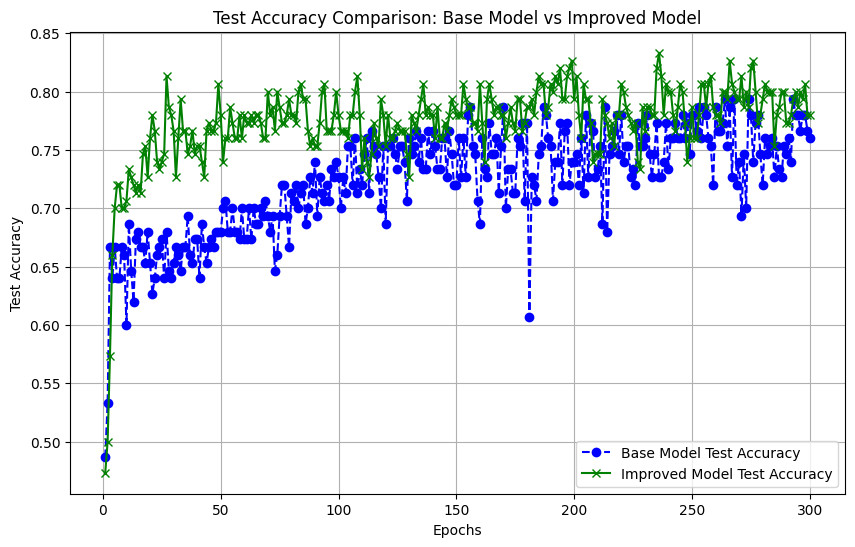

In [65]:
epochs_base = 300
epochs_improved = 300
epoch_range_base = np.arange(1, epochs_base + 1)
epoch_range_improved = np.arange(1, epochs_improved + 1)

plt.figure(figsize=(10, 6))

# We plot the test accuracy for the base model
plt.plot(epoch_range_base, test_accuracies_base_model, label='Base Model Test Accuracy', color='b', linestyle='--', marker='o')

# We plot the test accuracy for the best model
plt.plot(epoch_range_improved, test_accuracies_improved, label='Improved Model Test Accuracy', color='g', linestyle='-', marker='x')
plt.title('Test Accuracy Comparison: Base Model vs Improved Model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print()

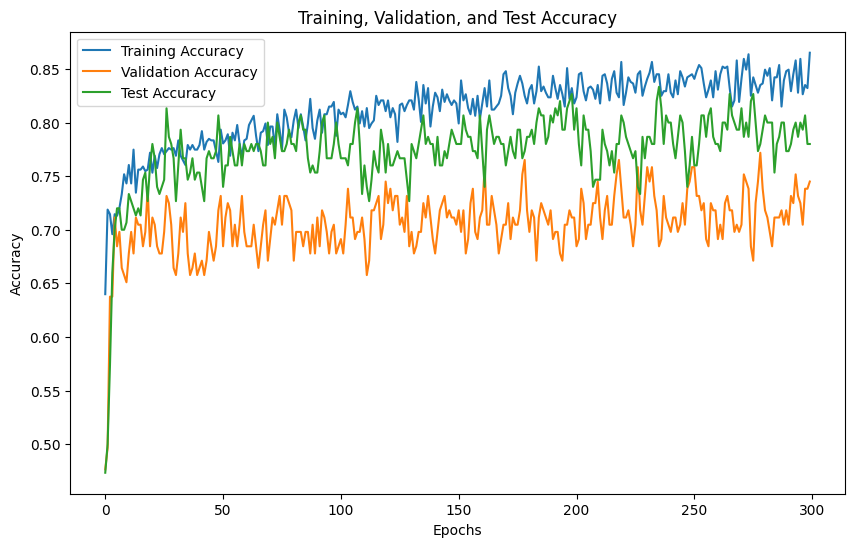

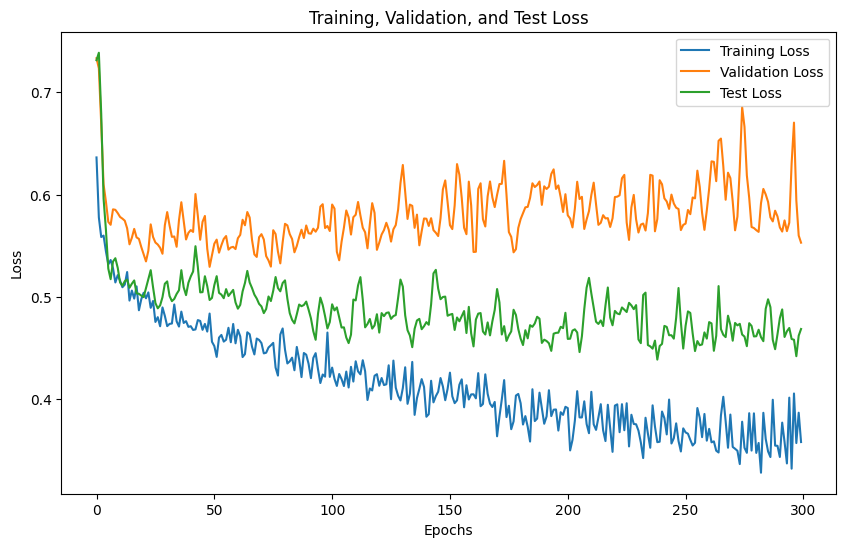

In [66]:
# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.plot(range(total_epochs), test_accuracies_improved, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), train_losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.plot(range(total_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


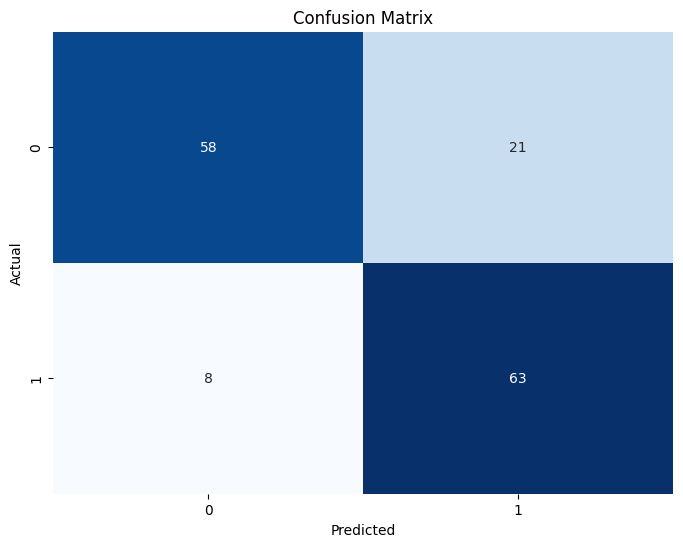

In [67]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Shishir\AppData\Local\Temp\ipykernel_43172\2629930344.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(y_true)
C:\Users\Shishir\AppData\Local\Temp\ipykernel_43172\2629930344.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred).float()


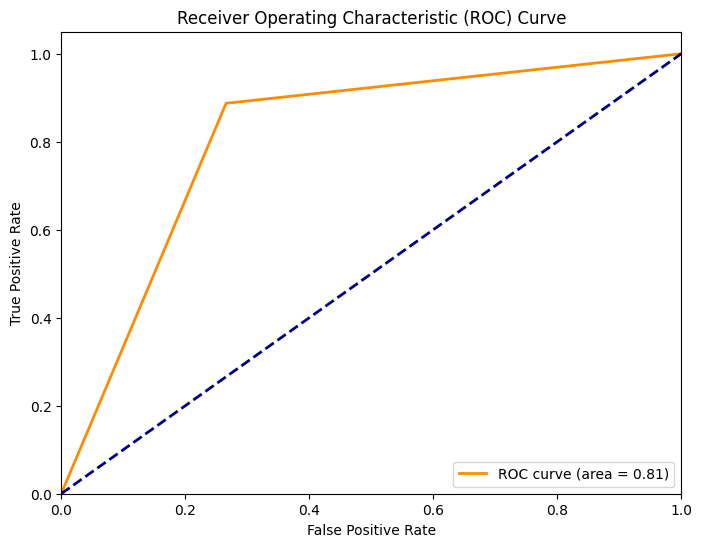

In [68]:
# ROC curve
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred).float()

fpr, tpr, thresholds = roc_curve(y_true_tensor, y_pred_tensor)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()